In [2]:
%matplotlib inline
#you may also try %matplotlib notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys, os
# Put the file hough_helpers into the subdirectory helpers.
sys.path.append(os.path.join(os.getcwd(), 'helpers'))
import hough_helpers

def disp_img(ax, img):
    ax.imshow(img, cmap='gray')
    ax.axis(False)

---
#### P3: Hough Transforms

---
<div class="alert alert-info">
<p>
University of Applied Sciences Munich<br>
Dept of Electrical Enineering and Information Technology<br>
Institute for Applications of Machine Learning and Intelligent Systems (IAMLIS)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(c) Alfred Schöttl 2023<br>
</p>
</div>

In this notebook, you shall detect straight lines defining the borders of a street utilizing the Hough transform.

## 1. Visualize the data
Read in the file `lanes.jpg` as _grayscale_ image. The image is large. Reduce the size by 2 in each dimension (function `cv2.resize`) and save the image in `img`. Print out the resulting shape and display it. You should see a grayscale image of a street, the image should have the size 2064 x 1161 pixels.

(2064, 1161)


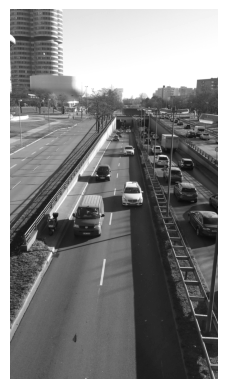

In [7]:
img = cv2.imread('../imgs/lanes.jpg', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (1161, 2064))

print(img.shape)                  # print the figure size
fig, ax = plt.subplots()
disp_img(ax, img)

## 2. Find edges
A good edge detector is the _Canny edge detector_. OpenCV already implements it, but without the important blurring preprocessing step we discussed in class. 
- We will therefore start with a blurring operation. Instead of implementing the convolution on our own, we may use a pre-built variant. `cv2.blur(..., ksize=(kx,ky))` implements a uniform blur, `cv2.GaussianBlur(..., ksize=(kx,yk), sigmaX=sig)` a Gaussian blur with kernel size `(kx,ky)` and standard deviation `sig` in units of pixels.
- The Canny algorithm is available by `cv2.Canny(..., threshold1=..., threshold2=...)` with threshold values as explained in class (use values in the 100th, and obey `threshold1`<`threshold2`). Call it to extract the edges and save the result in `edges`.
- Display the blurred image and the result of the Canny operation. Adapt the parameters of the blur and the Canny operator to your needs.

_Hint_: Do not blur too much. It may however be useful to cut off frequencies belonging to detailed textures (such as the grass on the bottom left of the image).

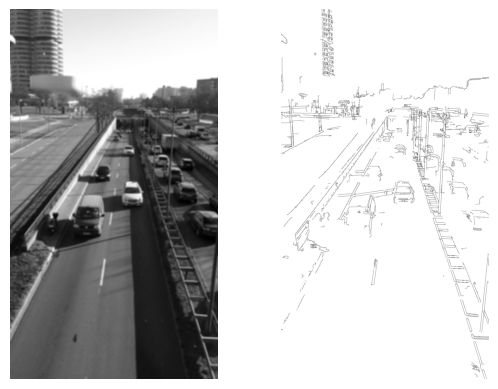

In [155]:

img_blur = cv2.blur(img, ksize=(11, 11))
edges = cv2.Canny(img_blur, threshold1=5, threshold2=100)

fig, axs = plt.subplots(1,2)
disp_img(axs[0], img_blur)
disp_img(axs[1], 255-edges)

## 3. Finding lines
We use the _Hough transform_ to find lines in the edge image `edges`. This implementation of the Hough transform uses the (standard) line model

$$ \rho = x \cos \vartheta + y \sin \vartheta\quad.
$$

Hence, $\rho$ is the shift of the line in pixels and $\vartheta$ is the angle in rad. $\vartheta=0$ corresponds to a vertical line ($\rho = x = \mathrm{const}$).
The method is available by `lines = cv2.HoughLinesWithAccumulator(..., rho=rho_res, theta=theta_res, threshold=1)`. `rho_res` and `theta_res` are the resolutions of `rho` (in pixels) and `theta` (in rad) used in the accumulator array. So, `rho_res`=50 (pixels) means that the accumulator array contains a row for each of the classes $\rho\in [0,50)$, $\rho\in [50,100)$, and so on. 

Choose reasonable values so that we can distinguish between significantly different lines on the one hand and that the array has a tractable size (in the 100th per dimension). The function returns a list `lines` of triples `(rho,theta,votes)` with the number of votes per line determined by `(rho, theta)`.

You may use the prepared function `hough_helpers.visualize_Hough(lines, rho_res, theta_res, rho_max, threed=...)` to visualize the Hough transform results. Play with it (and also consider the `threed=True` option). Interpret the output.

2369 91 <class 'int'>


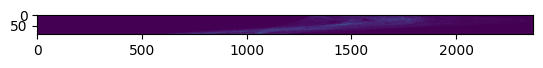

In [66]:
rho_resolution, theta_resolution = 1, np.pi/180

lines = cv2.HoughLinesWithAccumulator(edges, rho=rho_resolution, theta=theta_resolution, threshold=1)

rho_max = np.sqrt(edges.shape[0] ** 2 + edges.shape[1] ** 2)        # the maximum rho which shall be displayed
hough_helpers.visualize_Hough(lines, rho_resolution, theta_resolution, rho_max, threed=False)

## 4. Filter the line list
As already discussed, the `lines` lists consists of the tripes `(rho, theta, votes)`. We will filter out irrelevant lines. Two obvious criteria are:
- The number of votes for the line must exceed a certain threshold `min_votes`.
- The line should be roughly vertical. 

Use the Python command

`selected_lines = [(rho, theta) for ((rho, theta, votes),) in lines 
                                if (theta < theta1 or theta > theta2) and votes > min_votes]`

to filter out irrelevant lines. **Print out the number of lines selected**, which is the `len` of the list. Leave out the `(theta < theta1 or theta > theta2)` part in the selection for first if you are unsure.

Additional code to display the images with overlayed selected lines is already prepared for you. The overlay is done by creating new RGB images `edges_rgb` and `img_rgb` (of course with the gray-valued content) and changing their pixels to add cyan/red lines.

_Remark_: Strangely, the OpenCV Hough transform actually returns a list of lists with one triple each, `[[(rho1, theta1, votes1)], [(rho2, theta2, votes2)], ...]`. This is to allow for the same output data structure even with more complex algorithms and explains the double parantheses in the for statement above.

12
[[[-4.8400000e+02  2.8448865e+00  3.0500000e+02]]

 [[-4.5700000e+02  2.8274333e+00  2.9700000e+02]]

 [[ 1.2920000e+03  1.0471976e-01  2.8500000e+02]]

 ...

 [[ 3.7900000e+02  2.8972466e+00  2.0000000e+00]]

 [[ 3.3600000e+02  2.9146998e+00  2.0000000e+00]]

 [[ 3.3900000e+02  2.9146998e+00  2.0000000e+00]]]
img shape: (2064, 1161) img_rgb shape: (2064, 1161, 3)


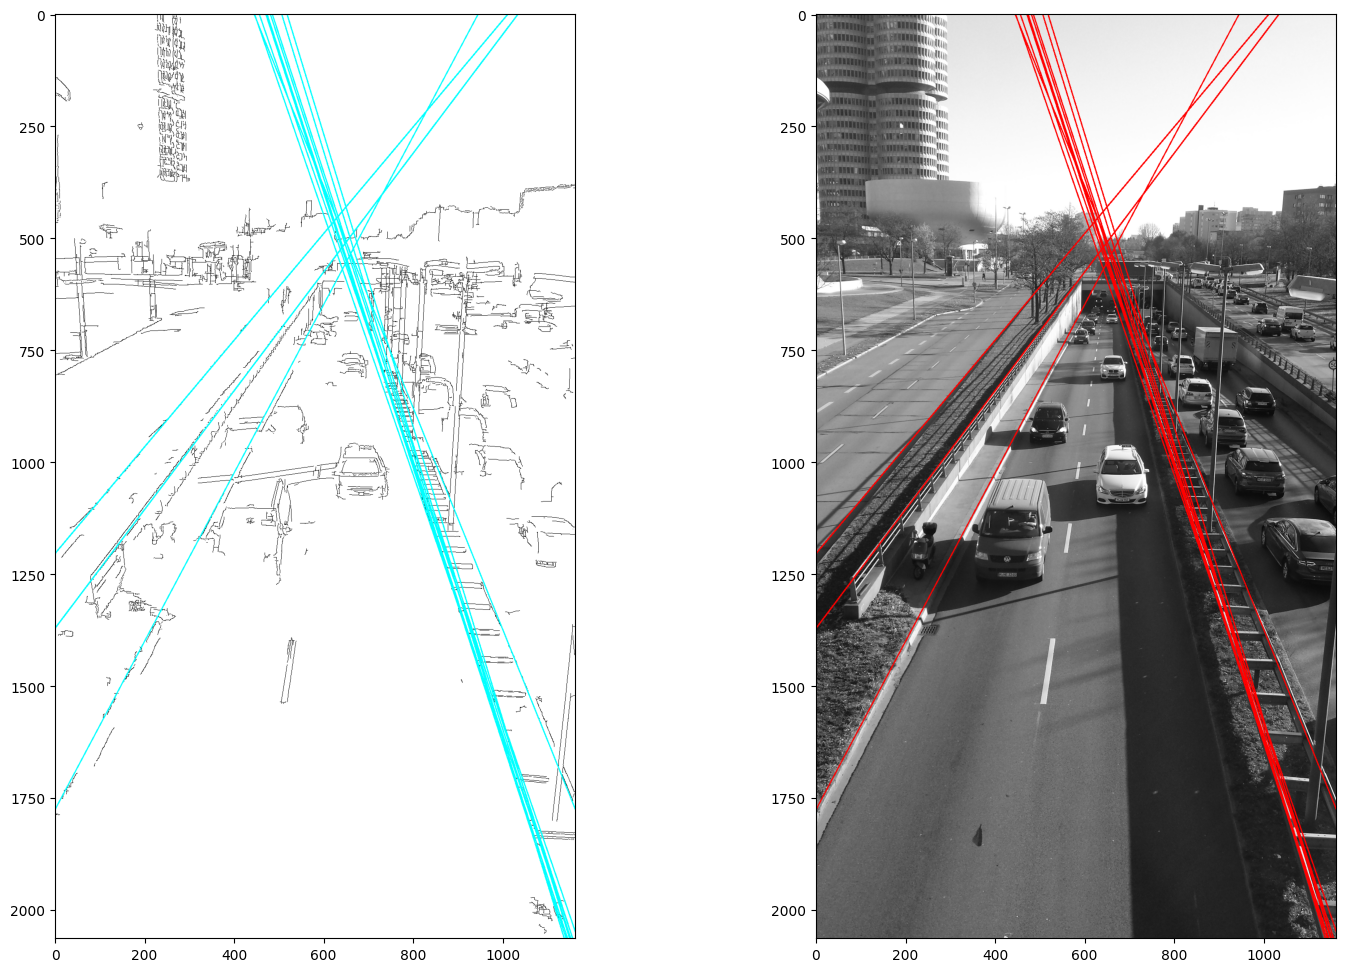

In [162]:
theta1 = 15 * np.pi/180
theta2 = 50 * np.pi/180

min_votes = 210

selected_lines = [(rho, theta) for ((rho, theta, votes),) in lines 
                                if (theta1 < theta < theta2 or np.pi - theta2 < theta < np.pi - theta1) and votes > min_votes]
print(len(selected_lines))
print(lines)
# add your code above this line
###############################
# we convert img in a color image (with grayscale content) so that we can add colored elements
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
print('img shape:', img.shape, 'img_rgb shape:', img_rgb.shape)

fig, axs = plt.subplots(1, 2, figsize=(18,12))
for line in selected_lines:
    hough_helpers.plot_line_in_img(line, edges_rgb)
axs[0].imshow(255-edges_rgb)
for line in selected_lines:
    hough_helpers.plot_line_in_img(line, img_rgb)
axs[1].imshow(img_rgb);

## 5. Postprocess the results
Section 4 gives the classical result of the Hough transform. We may have to postprocess the extracted lines to meet our needs. A simple example is shown below. We will use some helper functions in the module `hough_helpers` which are already prepared for you. 

Since we are considering a (approximately) straight and level road to infinity, all lines belonging to the road must intercept at the vanishing point ('Fluchtpunkt', point at infinity). Let us compute the intercept points of all line pairs and look out for a cluster. Select all lines which come close to the cluster center. You may change the parameter `dmax` and, if necessary, the maximum distance a selected line may pass the center.

_Tip:_ **The calculation may take a while**. Choose the parameters in the algorithms above so that only a moderate amount of lines (roughly 50) is selected.

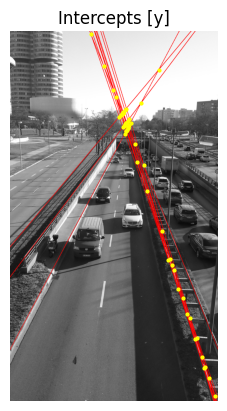

Cluster center: [651.40880907 526.54076026]


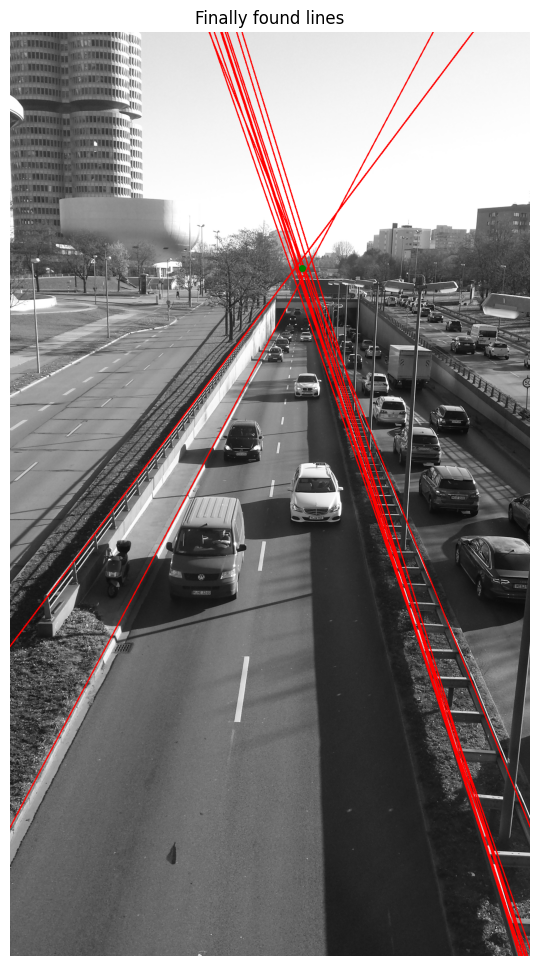

In [163]:
# Compute and display all intercept points
fig, ax = plt.subplots()
ax.set_title('Intercepts [y]')
intercepts = hough_helpers.find_intercepts(selected_lines)
for p in intercepts:
    if p[0] > 0 and p[1] > 0:
        ax.plot(p[0], p[1], color='yellow', marker='o', markersize=2)
ax.imshow(img_rgb)
ax.axis(False)
plt.show()

# Cluster the intercepts and find the cluster center
dmax = 50 # dmax: the range in within the intercept points have to lie to be considered a cluster
center = hough_helpers.find_cluster(intercepts, dmax)
print('Cluster center:', center)

# Select all lines close to the center
selected_lines2 = []
for line in selected_lines:
    d = abs(line[0] - np.cos(line[1])*center[0] - np.sin(line[1])*center[1])
    if d < 30:
        selected_lines2.append(line)

# Modify the image img and draw the selected lines into this image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for line in selected_lines2:
    hough_helpers.plot_line_in_img(line, img_rgb)
    
# Display the enhanced image
fig, ax = plt.subplots(figsize=(18,12))
plt.title('Finally found lines')
ax.plot(center[0], center[1], color='green', marker='o', markersize=4)
ax.imshow(img_rgb)
plt.axis(False)
plt.show()